In [20]:
from fastai.basics import *
from fastai.vision.all import *

from torchvision.models import resnet18, ResNet18_Weights
from tqdm import tqdm
from collections import defaultdict
import cmasher as cmr
import matplotlib.gridspec as gridspec
import timm

ROOT = Path("..").resolve()
seed = 256

device = "mps"

In [41]:
import matplotlib.font_manager as fm
from matplotlib.colors import LinearSegmentedColormap

fm.fontManager.addfont("/Users/john/Library/Fonts/Nunito-Italic.otf")
fm.fontManager.addfont("/Users/john/Library/Fonts/Nunito-Regular.otf")
fm.fontManager.addfont("/Users/john/Library/Fonts/Nunito-Bold.otf")
fm.fontManager.addfont("/Users/john/Library/Fonts/Nunito-ExtraBold.otf")

plt.rcParams['font.family'] = 'Nunito'
plt.rcParams['font.weight'] = "bold"
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.sf'] = 'Nunito'
plt.rcParams['mathtext.rm'] = 'Nunito'
plt.rcParams['mathtext.it'] = 'Nunito'
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=["#003f5c","#2f4b7c","#665191","#a05195","#d45087","#f95d6a","#ff7c43","#ffa600",])

In [21]:
zoobot = timm.create_model('hf_hub:mwalmsley/zoobot-encoder-resnet18').to(device)

In [6]:

df = pd.read_csv(ROOT / 'data/galaxies.csv', dtype={'objID': str})
df = df[(df.oh_p50 > 0) & (df.lgm_tot_p50 > 0) & (df.sfr_tot_p50 > -10)].copy()

n_galaxies = len(df)

# set a random state
rng = np.random.RandomState(seed)

In [7]:
# fastai "data blocks" determine how data can be fed into a model
dblock = DataBlock(
    blocks=(ImageBlock, RegressionBlock),
    get_x=ColReader('objID', pref=f'{ROOT}/data/images-sdss/', suff='.jpg'),
    get_y=ColReader('oh_p50'),
    splitter=RandomSplitter(0.2, seed=seed),
    item_tfms=[Resize(160), CropPad(144)],
    batch_tfms=aug_transforms(do_flip=True, flip_vert=True, max_rotate=0, max_zoom=1.0, max_warp=0, p_lighting=0) + [Normalize()]
)

# "data loaders" actually load the data 
dls = ImageDataLoaders.from_dblock(dblock, df, bs=64)

# Penultimate layer

In [ ]:
def get_zoobot_features(loader, model):
    # again get post-pool features
    activations = []
    with torch.no_grad():
        layers = nn.Sequential(*list(model.children())[:-1], nn.Flatten())
        
        for xb, _ in tqdm(loader):    
            activations.append(layers(xb))
    return torch.concat(activations, 0).cpu().numpy()

In [63]:
# gz_train_features = get_zoobot_features(dls.train.new(drop_last=False, shuffle=False), zoobot)
# gz_features = get_zoobot_features(dls.valid, zoobot)

  0%|          | 0/1466 [00:00<?, ?it/s]

100%|██████████| 1466/1466 [03:02<00:00,  8.01it/s]


In [64]:
gz_train_features_path = f"{ROOT}/results/resnet18-topk_4-metallicity/gz_train_features.npy"
gz_features_path = f"{ROOT}/results/resnet18-topk_4-metallicity/gz_features.npy"
# np.save(gz_train_features_path, gz_train_features)
# np.save(gz_features_path, gz_features)

gz_train_features = np.load(gz_train_features_path)
gz_features = np.load(gz_features_path)

0.18307452764378565


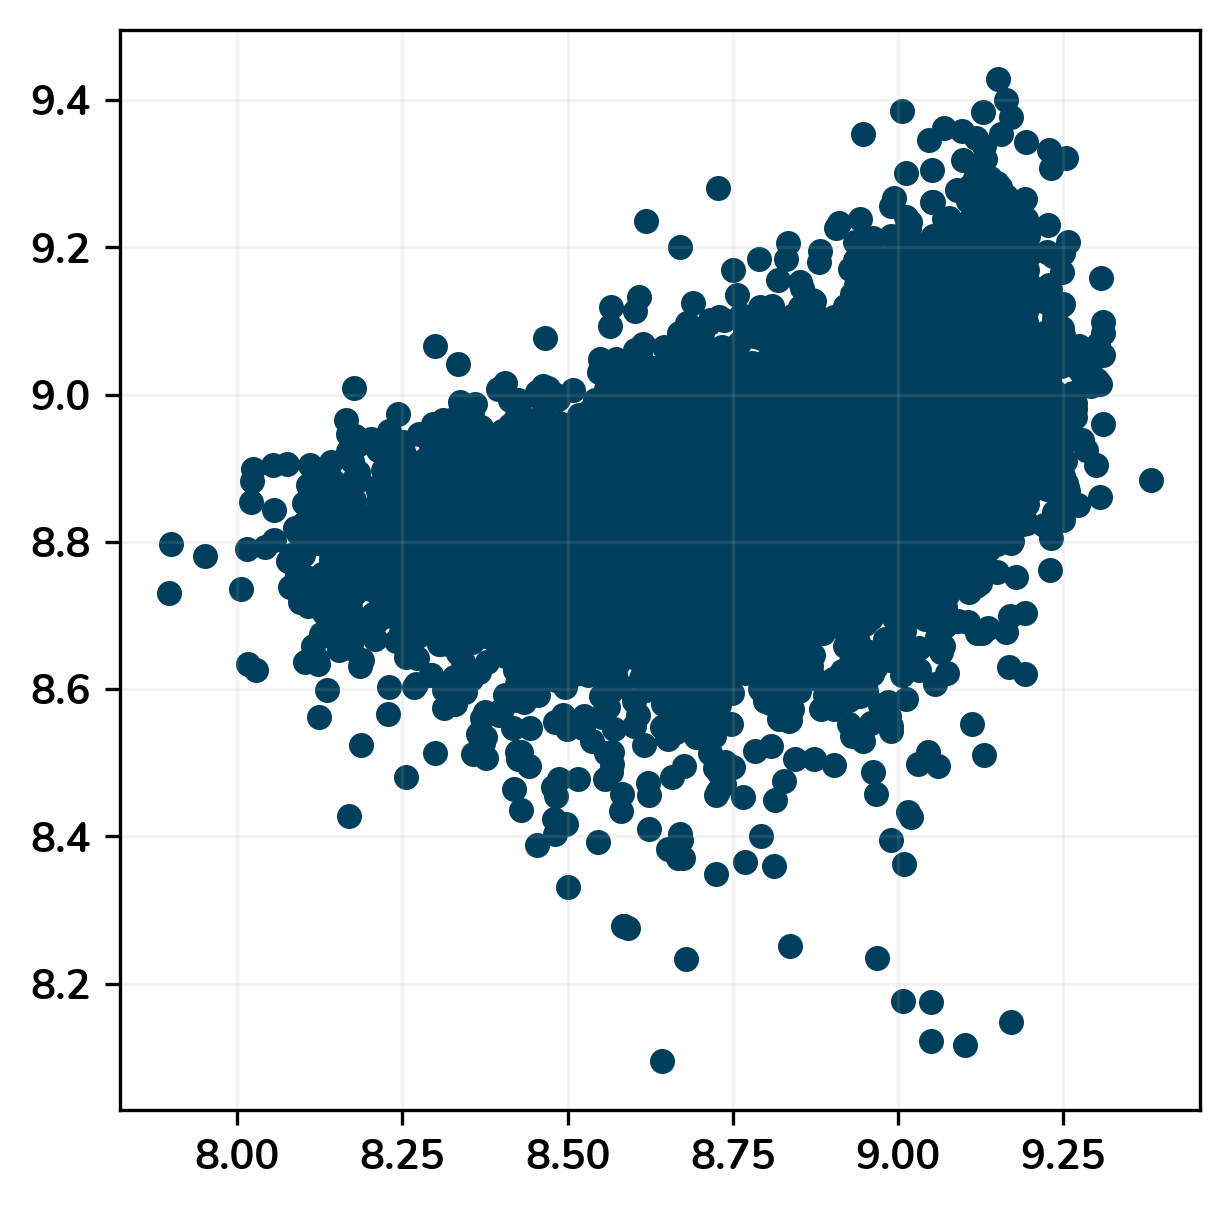

In [68]:
from sklearn.linear_model import LinearRegression

lin = LinearRegression()

lin.fit(gz_train_features, dls.train.items.oh_p50)

gz_preds = lin.predict(gz_features)
plt.scatter(dls.valid.items.oh_p50, gz_preds)
print(((dls.valid.items.oh_p50 - gz_preds)**2).mean()**0.5)

0.18055685043653424

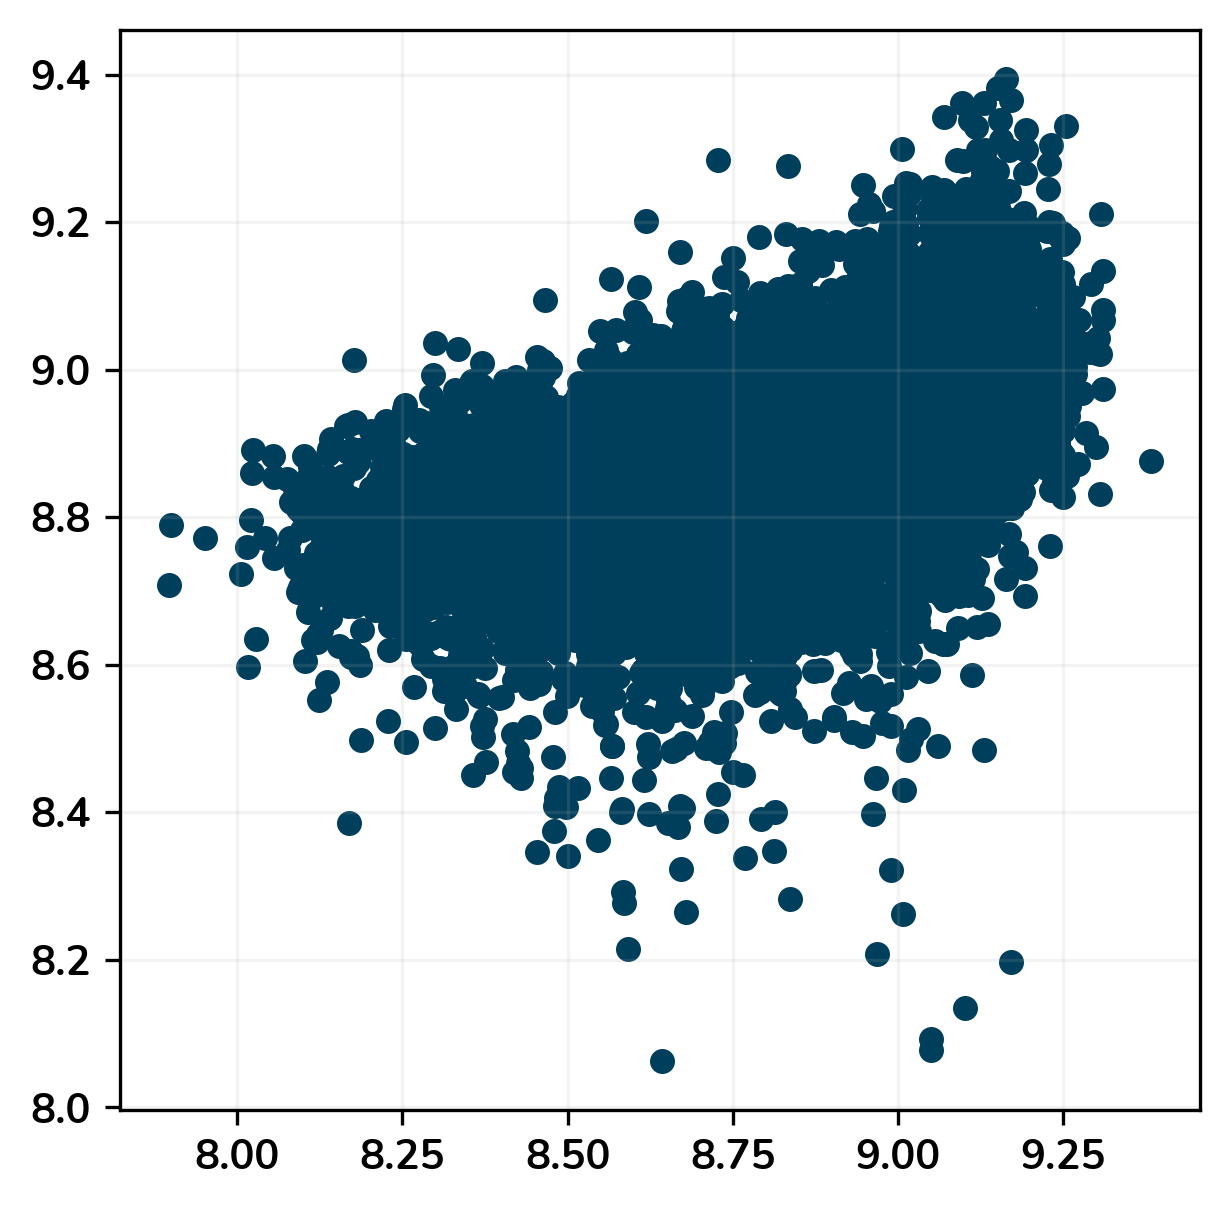

In [69]:

cheating_lin = LinearRegression()

cheating_lin.fit(gz_features, dls.valid.items.oh_p50)

gz_cheating_preds = cheating_lin.predict(gz_features)
plt.scatter(dls.valid.items.oh_p50, gz_cheating_preds)
((dls.valid.items.oh_p50 - gz_cheating_preds)**2).mean()**0.5

# xgboost?

In [ ]:
from xgboost import XGBRegressor

0.17966172304478345

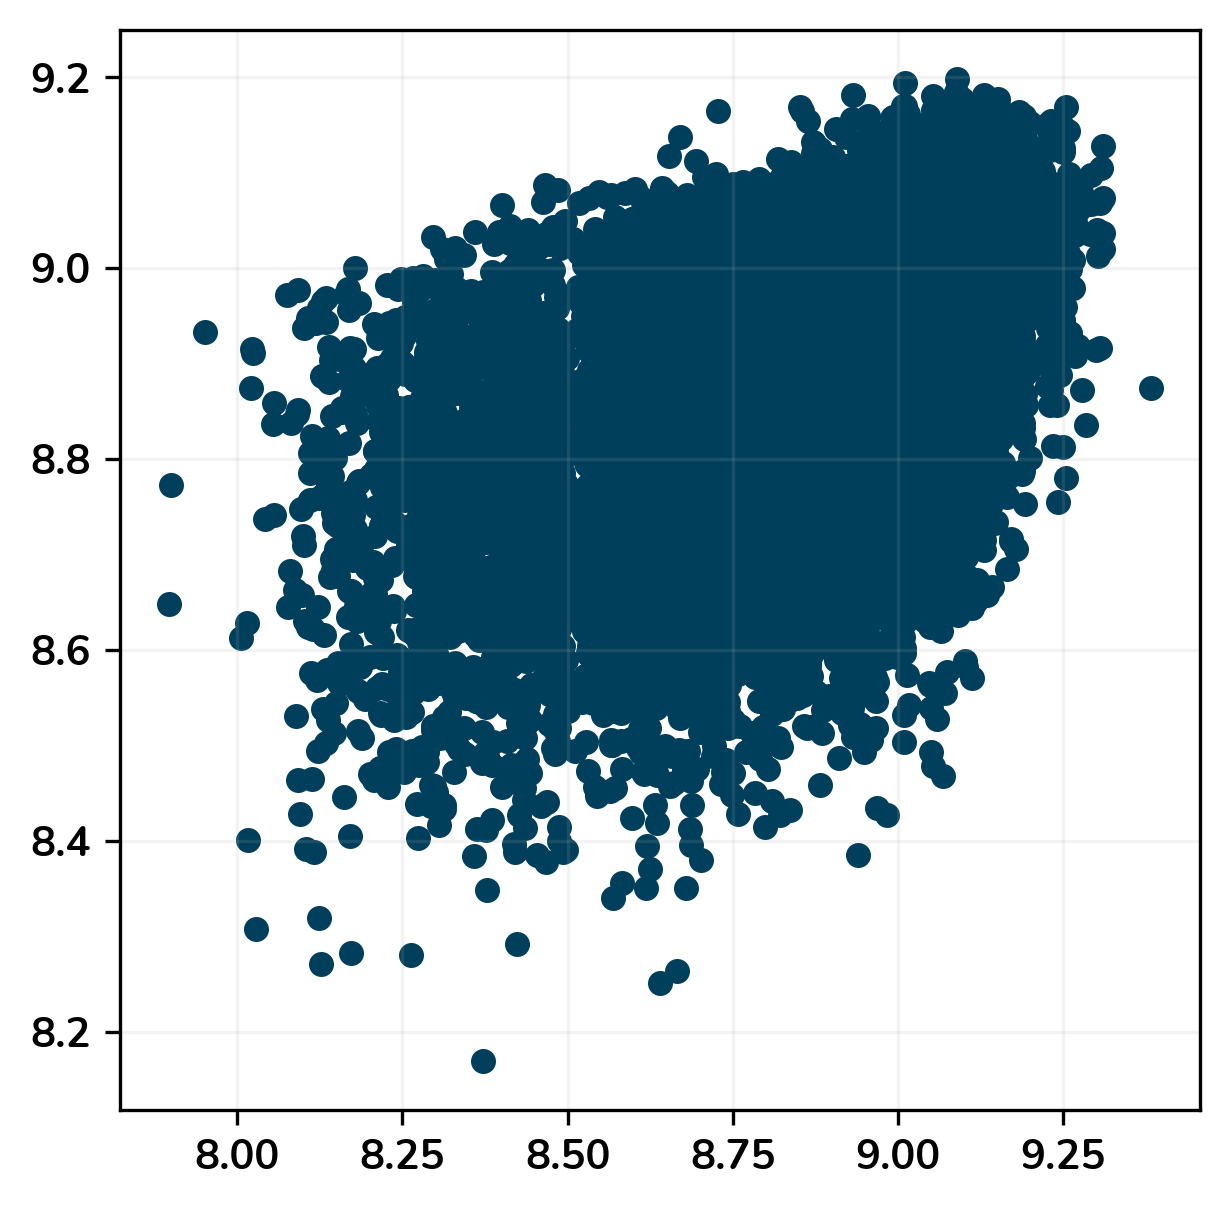

In [71]:

xgb = XGBRegressor()

xgb.fit(gz_train_features, dls.train.items.oh_p50)

gz_preds = xgb.predict(gz_features)
plt.scatter(dls.valid.items.oh_p50, gz_preds)

((dls.valid.items.oh_p50 - gz_preds)**2).mean()**0.5

0.08459107975675662

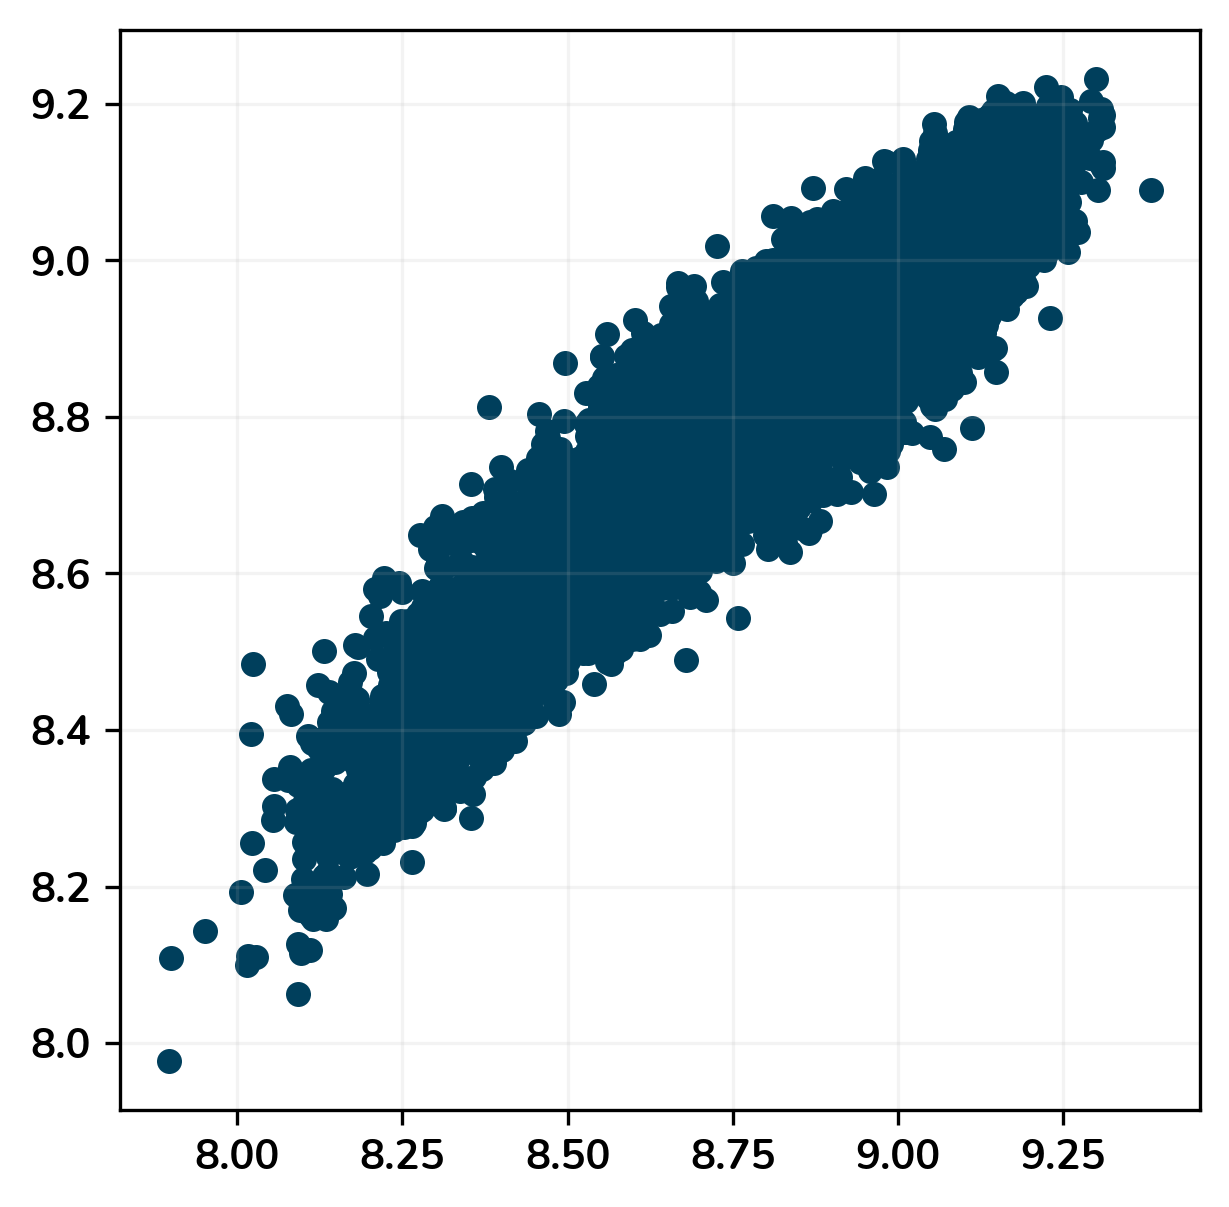

In [72]:

cheating_xgb = XGBRegressor()

cheating_xgb.fit(gz_features, dls.valid.items.oh_p50)

gz_cheating_preds = cheating_xgb.predict(gz_features)
plt.scatter(dls.valid.items.oh_p50, gz_cheating_preds)
((dls.valid.items.oh_p50 - gz_cheating_preds)**2).mean()**0.5